# <div align="center">Q-Agent on IGT      

# Game plan

1. add loss (negative rewards) possibility rather then have choices have either 1 positive posibility or 0
 - new variable 'pvalues' in objects: MultiArmedBandit, Qagent



2. add a 2nd alpha for loss (negative rewards)
 - changes need to be made in: MultiArmedBandit object, Qagent object
 - include conditional that checks for + or - negative "rewards" and changes alpha before computing (r is (+)rewards, p is (-)rewards):
 				Q(s,a) += alpha_g * (r + max,Q(s') - Q(s,a)) 
 				Q(s,a) += alpha_l * (p + max,Q(s') - Q(s,a)) 


3. use the actual decks of cards used for the IGT instead of randomized values for the decks
 - deck will come from a csv type file


4. explore the 3D of the parameter space - alpha, beta pairs and payoff
 - different alpha ratios
 - different alpha amplitudes
 - different beta amplitudes
 
 
 
5. change alpha used depending on RPE (reward prediction error), in update_Qi(), or whether (reward - Qval) >= 0, reward gains or (reward - Qval) < 0, reward loss


6. change all code from "Alpha reward" to "Alpha gains", and "Alpha punishments" to "Alpha loss"

7. Find the distribution (mean, histogram) of Payoff & Sensitivity scores from behavioral data

8. create a 2D heat maps for assymetry of learning and explore/exploit values
 - pick out agents that are greedy, moderate, etc, etc
 
       - Phase 1: test out all alpha gains in (positive range) and inverse for alpha losses, and 4 different betas (positive range). 
       Goal: find alpha amplitudes and betas that produce similar mean and variance as behavioral data.
     
       - Phase 2: keep alpha gains constant, and vary alpha loss (decending order, and then ascending order from inverse). 
       Goal: to find optimal alpha ratios and betas that produce similar mean and variance as behavioral data.






Thoughts
- create a curve of explore-exploit trade-off where the greediness increase the longer you've play and perhaps plateaus as you've played longer

- perhaps we should try mapping the IGT data for each participant to the agent's to find best fit parameters for the agent for each individual (this may help better narrow down the “true” story, is this about exploration or is this about alpha ratios, or both, or neither, etc.)

- should we look at cortical areas that are directly communicating/under the control of the ventral or dorsal medial cortex (close functional relationship)
 
---

## IGT game design 
100 Trials total (from Bechara, 1997)

|  | Deck A | Deck B | Deck C | Deck D |
| -------- | --- | --- | --- | --- | --- |
| p(gains) | 0.5 | 0.9 | 0.5 | 0.9 |
| g(losses) | 0.5 | 0.1 | 0.5 | 0.1 |
| avg gains | \$100 | \$100 | \$50 | \$50 |
| avg losses | -\$250 | -\$1250 | -\$50 | -\$250 |
| overall gains | -\$75 | -\$75 | \$0 | \$20 |


#### Alternative designs
- switch overall gains of C & D so that C has positive gains and keeps p(gains)=0.5, 
	and D has $0 gains and keeps p(gains)=0.9
	- may be interesting to see the effect of alpha on frequency of gains

In [1]:
from __future__ import division
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd
from pandas import DataFrame
from scipy.stats import sem
import seaborn as sns
import string
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
from __future__ import division
from future.utils import listvalues
from scipy.stats.stats import sem


In [2]:
def update_Qi(Qval, reward, alpha):
    """ update q-value of selected action, given reward and alpha
    alpha is changed depending on RPE (reward prediction error)
    (whether (reward - Qval) >= 0, reward gains or (reward - Qval) < 0, reward loss)
    """
    return Qval + alpha * (reward - Qval)

$$softmax$$  $$function = \frac {e^{\beta Q_i}}{\sum e^{\beta * Z_{vector}}} $$

$$for Q_i in Z_{vector}$$

* "...where T is a positive parameter called the temperature. High temperatures cause the actions to be all (nearly) equiprobable. Low temperatures cause a greater difference in selection probability for actions that differ in their value estimates."

inverse temperature = beta = greediness
* As temperature increases, beta decreases & greediness DECREASES (explorative)
* As temperature decreases, beta increases & greediness INCREASES (exploitative)

In [3]:
def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """ 
    Zvector = Qvector - max(Qvector)
    denom = np.sum(np.exp(beta * Zvector))
        
    resulting_pdata = np.array([np.exp(beta*Q_i) / denom for Q_i in Zvector])
    
    return resulting_pdata

In [4]:
class IowaGamblingTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N bandits
        rvalues (list): 1xN vector of payout values for each of N bandits
    """    
            
    def __init__(self):
                
        self.all_cards = pd.read_csv('IGTCards.csv')
        self.deck_gains = self.all_cards.sum()
        self.deck_counters = np.zeros(len(self.all_cards.columns), dtype = int)
        


    def get_feedback(self, action_ix):
    
        if self.deck_counters[action_ix] == 49:
            self.deck_counters[action_ix] = 0
        
        else:    
            self.deck_counters[action_ix] += 1
        
        curr_counter = self.deck_counters[action_ix]
        
        feedback = self.all_cards.iloc[curr_counter, action_ix]
        
        return feedback

In [5]:
class Qagent(object):

    """ defines the learning parameters of single q-learning agent
    in a multi-armed bandit task

    ::Arguments::
        alpha_g (float): learning rate for gains
        alpha_l (float): learning rate for losses
        beta (float): inverse temperature parameter
        preward (list): 1xN vector of reward probaiblities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
                        IF rvalues is None, all values set to 1
        pvalues (list): 1xN vector of punishment values for each of N decks
                        IF rvalues is None, all values set to 1

    """

    def __init__(self, alpha_g,
                       alpha_l, 
                       beta, 
                       epsilon=.1, 
                       decks=['A', 'B', 'C', 'D']):

        if decks is None:
            decks = ['A', 'B', 'C', 'D']

        # calling IowaGamblingTask() function with arguments in Qagent() object
        self.IGT = IowaGamblingTask()
        
        self.alpha_data = []
        
        self.rpe_data = []
        
        # setting parameters passed through Qagent() as arguments
        self.set_params(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, epsilon=epsilon, decks=decks)


    def set_params(self, **kwargs):
        
        """ update parameters of q-learning agent:
                alpha_g = learning rate for gains
                alpha_l = learning rate for losses
                beta = inv. temperature,
                epsilon = exploration constant to randomize decisions
                preward = probability of reward, p(reward)
                rvalues = reward amounts  (+$)
                pvalues = punishment amounts (-$)
        """

        kw_keys = list(kwargs)

        if 'alpha_g' in kw_keys:
            self.alpha_g = kwargs['alpha_g']

        if 'alpha_l' in kw_keys:
            self.alpha_l = kwargs['alpha_l']

        if 'beta' in kw_keys:
            self.beta = kwargs['beta']

        if 'epsilon' in kw_keys:
            self.epsilon = kwargs['epsilon']
        
        if 'decks' in kw_keys:
            self.decks = kwargs['decks']

        # number of choices/options
        self.nact = len(self.decks)

        # actions limited to number of choices/options
        self.actions = np.arange(self.nact)


    def play_IGT(self, ntrials=100, get_output=True):
        
        """ simulates agent performance on a multi-armed bandit task

        ::Arguments::
            ntrials (int): number of trials to play bandits
            get_output (bool): returns output DF if True (default)

        ::Returns::
            DataFrame (Ntrials x Nbandits) with trialwise Q and P
            values for each bandit
        """
        
        pdata = np.zeros((ntrials + 1, self.nact))
        
        pdata[0, :] = np.array([1/self.nact]*self.nact)
        
        qdata = np.zeros_like(pdata)
        self.choices = []
        self.feedback = []

        for t in range(ntrials):

            # select bandit arm (action)            
            act_i = np.random.choice(self.actions, p=pdata[t, :])
            
            # observe feedback
            r = self.IGT.get_feedback(act_i)

            # update value of selected action depending on whether it is a gain or loss
            rpe = r - qdata[t, act_i]
            if rpe >= 0:
                alpha = self.alpha_g
            if rpe < 0:
                alpha = self.alpha_l
            
            qdata[t+1, act_i] = update_Qi(qdata[t, act_i], r, alpha)

            # broadcast old q-values for unchosen actions
            for act_j in self.actions[np.where(self.actions!=act_i)]:
                qdata[t+1, act_j] = qdata[t, act_j]

            # update action selection probabilities and store data
            pdata[t+1, :] = update_Pall(qdata[t+1, :], self.beta)
            
            self.choices.append(act_i)
            self.feedback.append(r)
            self.rpe_data.append(rpe)
            self.alpha_data.append(alpha)
        
        self.pdata = pdata[1:, :]
        self.qdata = qdata[1:, :]
        self.make_output_df()

        if get_output:
            return self.data.copy()


    def make_output_df(self):
        """ generate output dataframe with trialwise Q and P measures for each bandit,
        as well as choice selection, and feedback
        """
        df = pd.concat([pd.DataFrame(dat) for dat in [self.qdata, self.pdata]], axis=1)
        columns = np.hstack(([['{}{}'.format(x, c) for c in self.actions] for x in ['q', 'p']]))
        df.columns = columns
        df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
        df['choice'] = self.choices
        df['feedback'] = self.feedback
        
        # replace 3 with self.IGT.deck_gains.values.argmax()
        df['optimal'] = np.where(df['choice']==3, 1, 0)
        df['RPE'] = self.rpe_data
        df['alpha'] = self.alpha_data
        df.insert(0, 'agent', 1)
        self.data = df.copy()


    def simulate_multiple(self, nsims=10, ntrials=1000):
        """ simulates multiple identical agents on multi-armed bandit task
        """
        dflist = []
        for i in range(nsims):
            data_i = self.play_bandits(ntrials=ntrials, get_output=True)
            data_i['agent'] += i
            dflist.append(data_i)
        return pd.concat(dflist)

In [6]:
def get_optimal_auc(df, nblocks=25, verbose=False, as_percent=True):
    xdf = blockify_trials(df, nblocks=nblocks)
    muOptDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    auc = pd.pivot_table(muOptDF, values='optimal', index='block').values.sum()
    if as_percent:
        auc = (auc / nblocks) * 100
        print("Optimal Choice chosen {:.2f}% of time".format(auc))
    if verbose:
        print("Optimal Choice chosen {:.2f} times".format(auc))

    return auc

def analyze_bandits(df, nblocks=25, get_err=False):
    xdf = blockify_trials(df, nblocks=nblocks)
    optDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    muOpt = pd.pivot_table(optDF, values='optimal', index='block').values
    muOpt = np.hstack(muOpt)
    if get_err:
        errOpt = pd.pivot_table(optDF, values='optimal', index='block', aggfunc=sem).values*1.96
        errOpt = np.hstack(errOpt)
    else:
        errOpt = np.zeros_like(muOpt)
    return muOpt, errOpt

def blockify_trials(data, nblocks=5, conds=None, groups=['agent']):

    datadf = data.copy()
    if conds is not None:
        if type(conds) is str:
            conds = [conds]
        groups = groups + conds

    idxdflist = []
    for dfinfo, idxdf in datadf.groupby(groups):
        ixblocks = np.array_split(idxdf.trial.values, nblocks)
        blocks = np.hstack([[i+1]*arr.size for i, arr in enumerate(ixblocks)])
        idxdf = idxdf.copy()
        colname = 'block'
        idxdf[colname] = blocks
        idxdflist.append(idxdf)

    return pd.concat(idxdflist)


In [7]:
def plot_qlearning(data, nblocks=25, analyze=True):

    if analyze:
        auc = get_optimal_auc(data, nblocks, as_percent=True)

    sns.set(style='white', font_scale=1.3)
    clrs = ['#3778bf', '#feb308', '#9b59b6', '#2ecc71', '#e74c3c',
            '#3498db', '#fd7f23', '#694098', '#319455', '#f266db',
            '#13579d', '#fa8d67'  '#a38ff1'  '#3caca4', '#c24f54']

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3.5))
    df = data.copy()
    nactions = int(df.columns[-4].split('p')[-1])+1
    actions = np.arange(nactions)

    mudf = df.groupby('trial').mean().reset_index()
    errdf = df.groupby('trial').sem().reset_index()*1.96
    x = mudf.trial.values

    plot_err = True
    if np.isnan(errdf.loc[1, 'q0']):
        plot_err = False

    x3 = np.arange(1, nblocks+1)
    chance = 1/nactions
    mu3, err3 = analyze_bandits(df, nblocks=nblocks, get_err=plot_err)
    ax3.plot(x3, mu3, color='k')
    ax3.hlines(chance, 1, x3[-1], color='k', linestyles='--', label='chance')

    for i, act in enumerate(actions):
        muQ = mudf['q{}'.format(act)].values
        muP = mudf['p{}'.format(act)].values
        ax1.plot(x, muQ, label='$arm_{}$'.format(i), color=clrs[i])
        ax2.plot(x, muP, color=clrs[i])

        if plot_err:
            errQ = errdf['q{}'.format(act)].values
            errP = errdf['p{}'.format(act)].values
            ax1.fill_between(x, muQ-errQ, muQ+errQ, color=clrs[i], alpha=.2)
            ax2.fill_between(x, muP-errP, muP+errP, color=clrs[i], alpha=.2)
            if i==0:
                ax3.fill_between(x3, mu3-err3, mu3+err3, color='k', alpha=.15)
        else:
            ychance = np.ones(mu3.size) * chance
            mu3A = np.copy(mu3)
            mu3B = np.copy(mu3)
            mu3A[np.where(mu3<=chance)] = chance
            mu3B[np.where(mu3>=chance)] = chance
            ax3.fill_between(x3, ychance, mu3A, color='#2ecc71', alpha=.15)
            ax3.fill_between(x3, ychance, mu3B, color='#e74c3c', alpha=.15)

    ax1.legend(loc=4)
    ax1.set_ylabel('$Q(arm)$')
    ax1.set_title('Value')

    ax2.set_ylabel('$P(arm)$')
    ax2.set_ylim(0,1)
    ax2.set_title('Softmax Prob.')

    ax3.set_ylim(0,1)
    ax3.set_ylabel('% Optimal Deck')
    ax3.set_xticks([1, nblocks+1])
    ax3.set_xticklabels([1, df.trial.max()])
    ax3.legend(loc=4)

    for ax in f.axes:
        ax.set_xlabel('Trials')
    plt.tight_layout()
    sns.despine()


In [8]:
def get_IGT_scores(data):
    
    # initializing a choice dictionary with the default of 0 times chosen
    choice_dict = {0: 0, 1:0, 2:0, 3:0}
    
    # updating the choice dictionary with the deck choices made
    choices_made = data['choice'].value_counts(sort = False).to_dict()
    
    for key, value in choices_made.items():
        choice_dict[key] = value

    A, B, C, D = choice_dict.get(0), choice_dict.get(1), choice_dict.get(2), choice_dict.get(3)
    
    # Payoff (P)
    payoff = (C + D) - (A + B)
    
    # Sensitivity to frequency of gains (Q)
    sensitivity = (B + D) - (A + C)
    
    return pd.Series((payoff, sensitivity))

In [120]:
def plot_heatmaps(data):
    
    plt.figure(figsize=(18, 14))
    heatmap_df = pd.pivot(data, index = "Alpha Loss", columns = "Alpha Gain", values = "Payoff").astype('float')
    
    
    sns.heatmap(heatmap_df, linewidths=.2, cmap='RdBu_r', vmin=-100, vmax=100).invert_yaxis()

In [103]:
def agent_df_0(amin, amax, astep, given_beta):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(dtype=float, columns=df_columns)
    
    for cycle in np.arange(0, 2, 1): 
        
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(amin, amax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for ratio in np.arange(0, 20, .1):

                alpha_l = ratio*alpha_g
                beta = given_beta
                
                alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 3)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

In [104]:
# agent_df_0(amin, amax, astep, given_beta)
mydf = agent_df_0(0, 12, .5, .2)

In [119]:
mydf

,Alpha Gain,Alpha Loss,Beta,Payoff,Sensitivity
0,0.0,0.00,0.2,-0.66,0.25
1,0.5,0.00,0.2,0.00,100.00
2,0.5,0.05,0.2,-100.00,100.00
3,0.5,0.10,0.2,74.00,82.00
4,0.5,0.15,0.2,67.00,20.00
5,0.5,0.20,0.2,72.00,-56.00
6,0.5,0.25,0.2,76.00,-66.00
7,0.5,0.30,0.2,76.00,-66.00
8,0.5,0.35,0.2,76.00,-66.00
9,0.5,0.40,0.2,76.00,-66.00


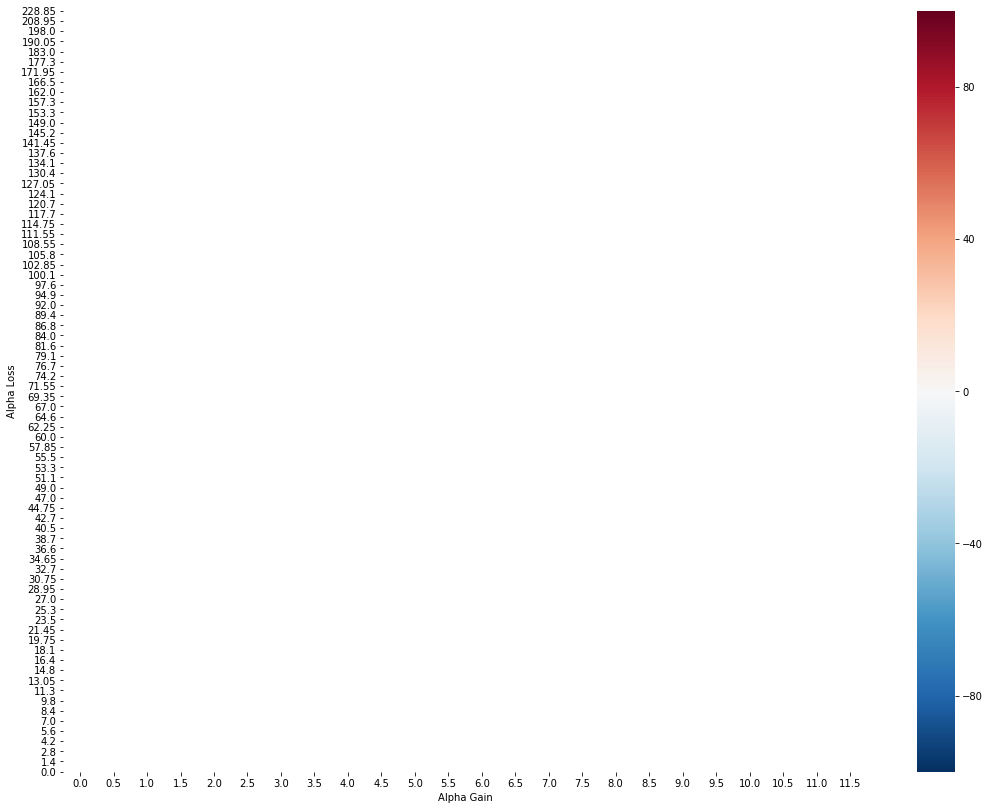

In [121]:
mydf = mydf.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(mydf)

In [109]:
def agent_df(amin, amax, astep, given_beta):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(dtype=float, columns=df_columns)
    
    for cycle in np.arange(0, 2, 1): 
        
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(amin, amax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for alpha_l in np.arange(amin, amax, astep):

                beta = given_beta
                
                alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 3)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

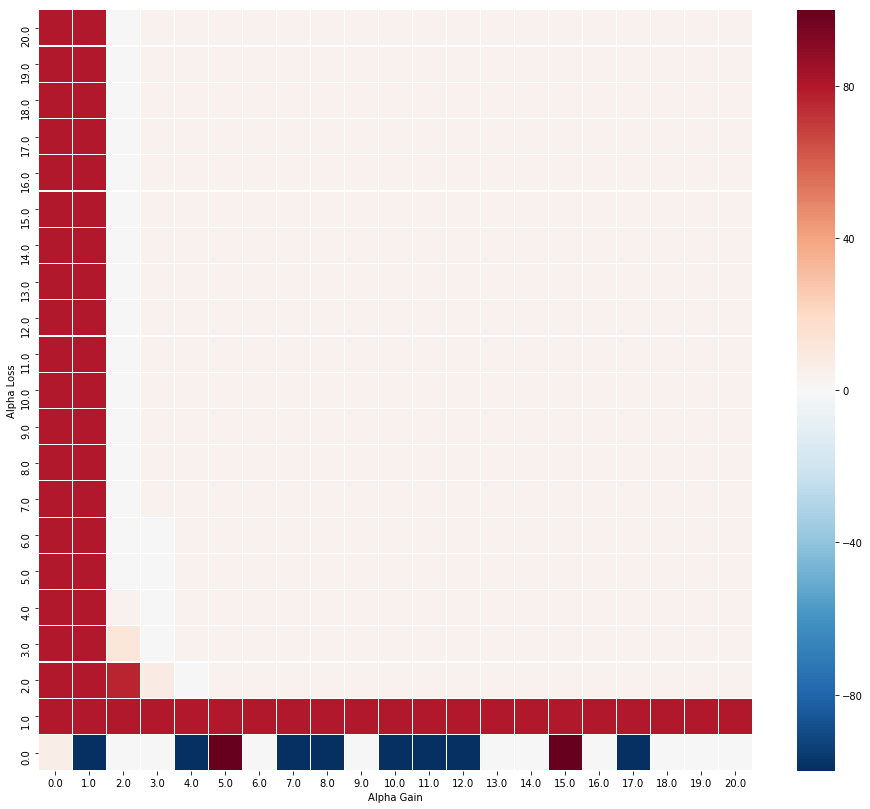

In [110]:
mydf2 = agent_df(0, 21, 1, .2)
mydf2 = mydf2.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(mydf2)

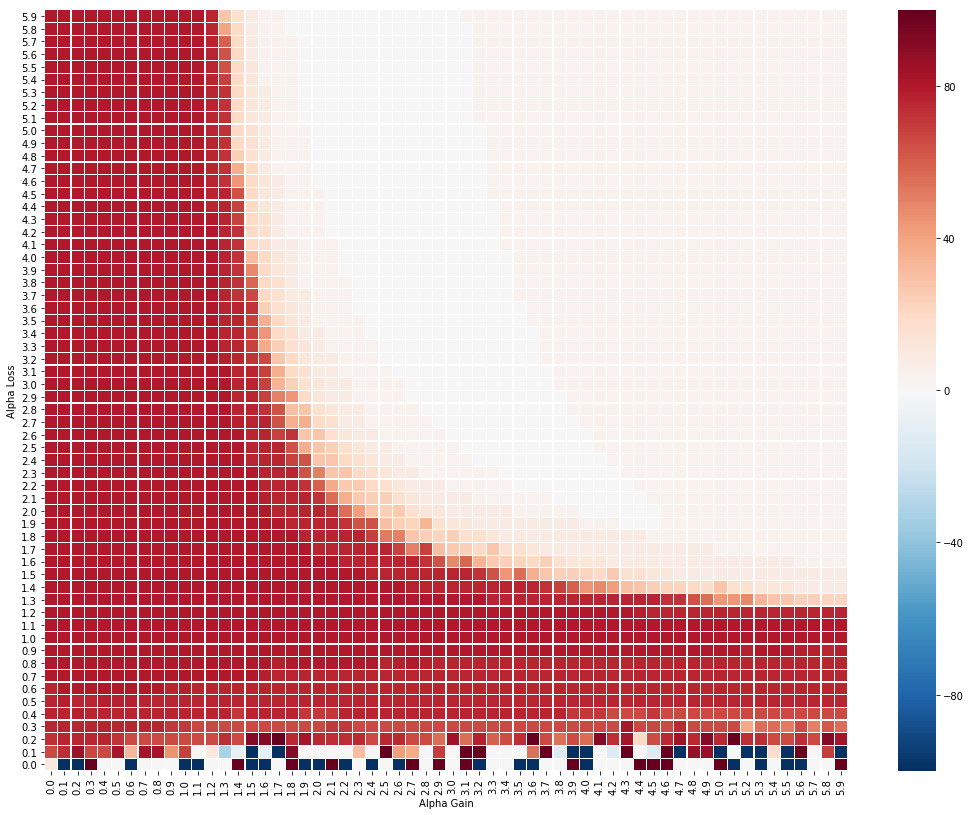

In [122]:
mydf3 = agent_df(0, 6, .1, .2)
mydf3 = mydf3.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(mydf3)

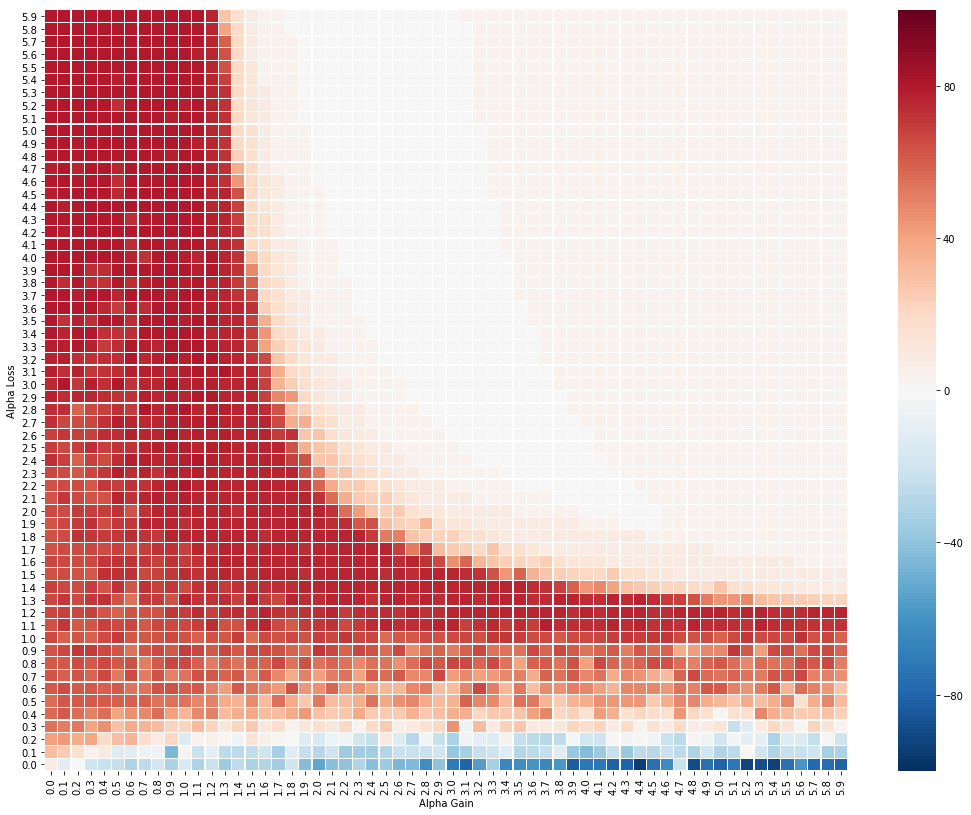

In [123]:
mydf3 = agent_df(0, 6, .1, .01)
mydf3 = mydf3.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(mydf3)

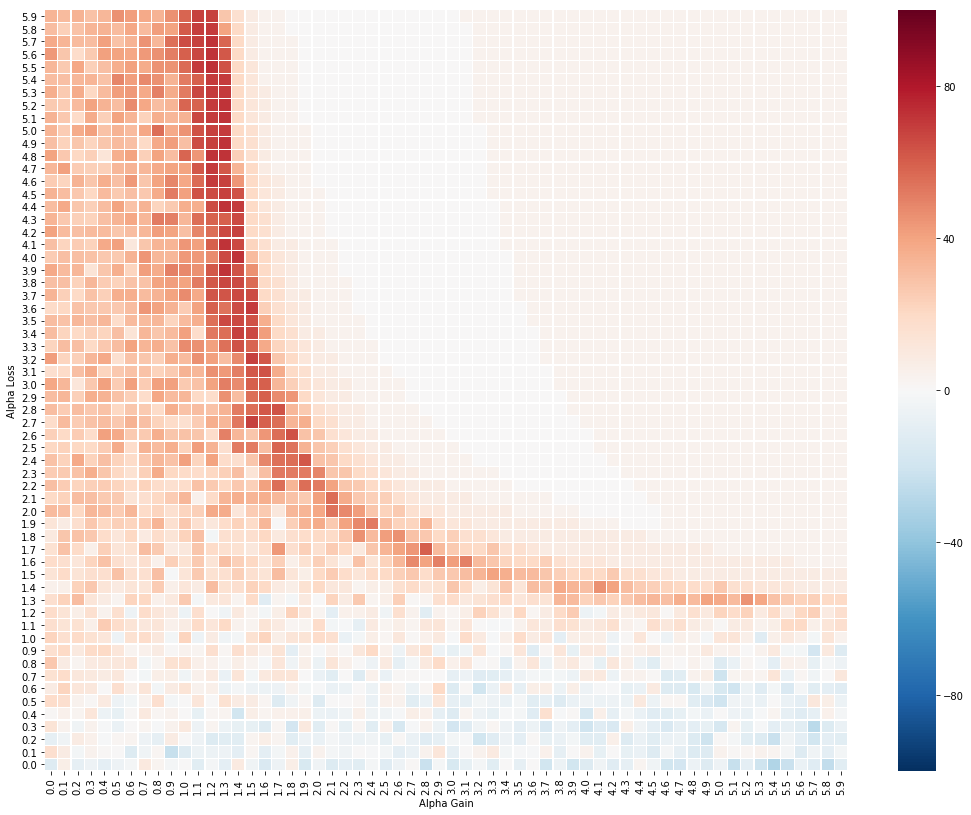

In [124]:
mydf3 = agent_df(0, 6, .1, .001)
mydf3 = mydf3.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(mydf3)

In [111]:
def agent_subject_comparison(df):
    
    # Creating agent Payoff df
    agent_full_df = df
    agent_P_df = pd.to_numeric(agent_full_df["Payoff"])
    agent_Q_df = pd.to_numeric(agent_full_df["Sensitivity"])
    
    # Creating Noncarrier Payoff df
    full_df = pd.read_csv("DRD2_IGT_subset_data.csv")
    P_df = full_df[full_df["IGT_score_type"] == "P"]
    Q_df = full_df[full_df["IGT_score_type"] == "Q"]
    noncarrier_P_df = P_df[P_df["DRD2"] == 0]["IGT_scores"]
    noncarrier_Q_df = Q_df[Q_df["DRD2"] == 0]["IGT_scores"]
    carrier_P_df = P_df[P_df["DRD2"] == 1]["IGT_scores"]
    carrier_Q_df = Q_df[Q_df["DRD2"] == 1]["IGT_scores"]
    
    # Setting subplot dimensions & size
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,10))
    
    # Setting color of histogram depending on whether there is a mean match
    match = 'steelblue'
    P_match_presence = False
    Q_match_presence = False
    
    # Calculating means
    noncarrier_P_mean = round(noncarrier_P_df.mean(), 0)
    carrier_P_mean = round(carrier_P_df.mean(), 0)
    agent_P_mean = round(agent_P_df.mean(), 0)
    noncarrier_Q_mean = round(noncarrier_Q_df.mean(), 0)
    carrier_Q_mean = round(carrier_Q_df.mean(), 0)
    agent_Q_mean = round(agent_Q_df.mean(), 0)
    
    # Plotting histogram for Noncarrier Payoff scores
    if noncarrier_P_mean in np.arange(agent_P_mean-5, agent_P_mean+5): 
        match = 'g'
        P_match_presence = True
    ax1.hist(noncarrier_P_df, bins=50, range=(-100,100), color = match)
    ax1.axvline(noncarrier_P_mean, color='k', linestyle='dashed', linewidth=1)
    ax1.set_title("Noncarrier Payoff (P) \n with Mean: " + str(noncarrier_P_mean))
    match = 'steelblue'
    
    # Plotting histogram for Carrier Payoff scores
    if carrier_P_mean in np.arange(agent_P_mean-5, agent_P_mean+5): 
        match = 'g'
        P_match_presence = True
    ax2.hist(carrier_P_df, bins=50, range=(-100,100), color = match)
    ax2.axvline(carrier_P_mean, color='k', linestyle='dashed', linewidth=1)
    ax2.set_title("Carrier Payoff (P) \n with Mean: " + str(carrier_P_mean))
    match = 'steelblue'
    
    # Plotting histogram for Agent Payoff scores
    if P_match_presence == True: 
        match = 'g'
    ax3.hist(agent_P_df, bins=30, range=(-100,100), color = match)
    ax3.axvline(agent_P_mean, color='k', linestyle='dashed', linewidth=1)
    ax3.set_title("Q-Agent Payoff (P) \n with Mean: " + str(agent_P_mean))
    match = 'steelblue'
    
    # Plotting histogram for Noncarrier Payoff scores
    if noncarrier_Q_mean in np.arange(agent_Q_mean-5, agent_Q_mean+5): 
        match = 'g'
        P_match_presence = True
    ax4.hist(noncarrier_Q_df, bins=50, range=(-100,100), color = match)
    ax4.axvline(noncarrier_Q_mean, color='k', linestyle='dashed', linewidth=1)
    ax4.set_title("\n \n Noncarrier Sensitivity (Q) \n with Mean: " + str(noncarrier_Q_mean))
    match = 'steelblue'
    
    # Plotting histogram for Carrier Payoff scores
    if carrier_Q_mean in np.arange(agent_Q_mean-5, agent_Q_mean+5): 
        match = 'g'
        Q_match_presence = True
    ax5.hist(carrier_Q_df, bins=50, range=(-100,100), color = match)
    ax5.axvline(carrier_Q_mean, color='k', linestyle='dashed', linewidth=1)
    ax5.set_title("\n \n Carrier Sensitivity (Q) \n with Mean: " + str(carrier_Q_mean))
    match = 'steelblue'
    
    # Plotting histogram for Agent Payoff scores
    if Q_match_presence == True: 
        match = 'g'
    ax6.hist(agent_Q_df, bins=30, range=(-100,100), color = match)
    ax6.axvline(agent_Q_mean, color='k', linestyle='dashed', linewidth=1)
    ax6.set_title("\n \n Q-Agent Sensitivity (Q) \n with Mean: " + str(agent_Q_mean))
    
    
    ax5.set_xlabel("\n Scores",fontsize=14)
    plt.tight_layout()


# Phase 1
Testing range for alpha gain & alpha loss with betas 0.0001, 0.001, 0.01, 0.1.

In [ ]:
def agent_df_1(amin, amax, astep, given_beta):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(columns=df_columns)
    
    for cycle in np.arange(0, 10, 1): 
    
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(amin, amax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for alpha_l in np.arange(amin, amax, astep):

                #for beta in np.arange(0, 20, 5):
                beta = given_beta
                alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 1)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

In [ ]:
# alpha gain range 0-3 (.1 steps)
# beta = .0001
testdf_3 = agent_df_1(0, 3, .1, .0001)
agent_subject_comparison(testdf_3)

In [ ]:
# alpha gain range 0-3 (.1 steps)
# beta = .001
testdf_4 = agent_df_1(0, 3, .1, .001)
agent_subject_comparison(testdf_4)

In [ ]:
# alpha gain range 0-3 (1 steps)
# beta = .01
testdf_1 = agent_df_1(0, 3, .1, .01)
agent_subject_comparison(testdf_1)

In [ ]:
# alpha gain range 0-3 (1 steps)
# beta = .1
testdf_2 = agent_df_1(0, 3, .1, .1)
agent_subject_comparison(testdf_2)

# Phase 2
Testing alpha ratios while keeping alpha gains at 10 & beta at .1 constant 

In [127]:
def agent_df_2(amin, amax, astep, given_beta, given_alpha, heatmap = False):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(columns=df_columns)
    
    for cycle in np.arange(0, 10, 1): 
    
        alpha_g = given_alpha
        beta = given_beta


        # alpha should only be positive, 0 to 1 for example
        for mult in np.arange(amin, amax, astep):

            # testing all alpha ratios from amin to amax
            alpha_l = mult*alpha_g


            # for beta in np.arange(0, 20, 5):

            alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 1)
            agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta)
            data = agent.play_IGT(ntrials=100, get_output=True)
            scores = get_IGT_scores(data)
            payoff, sensitivity = scores.iloc[0], scores.iloc[1]
            trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, payoff, sensitivity]], columns = df_columns)
            df = df.append(trial_df)
            df.reset_index(drop=True, inplace=True)

    return df

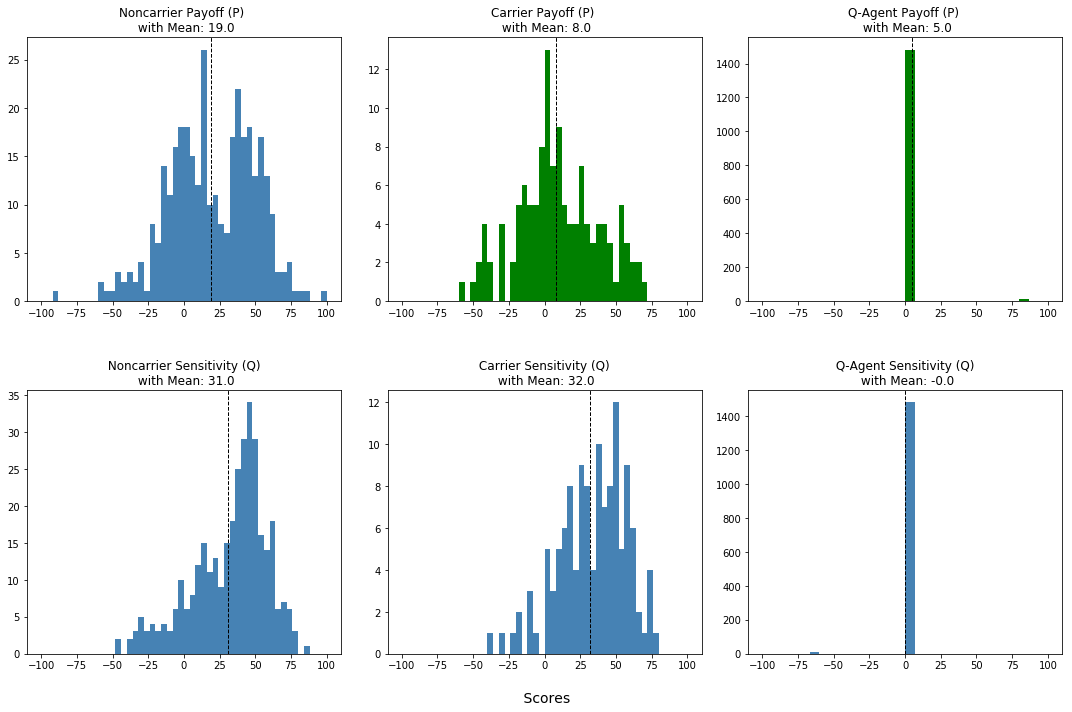

In [128]:
# alpha ratios in range .1-10 (.5 steps)
# beta = .01
# alpha gains = 10
testdf_5 = agent_df_2(.1, 15, .1, .1, 10)
agent_subject_comparison(testdf_5)

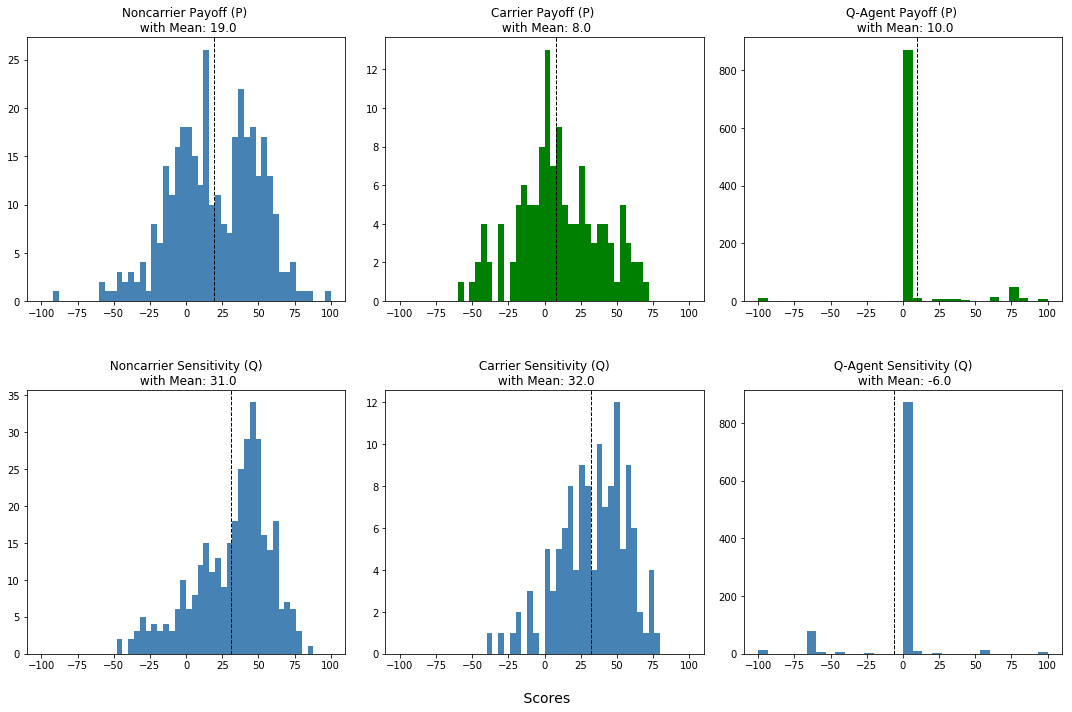

In [129]:
# alpha ratios in range .01-5 (.1 steps)
# beta = .01
# alpha gains = 10
testdf_7 = agent_df_2(.001, 1, .01, .1, 10)
agent_subject_comparison(testdf_7)

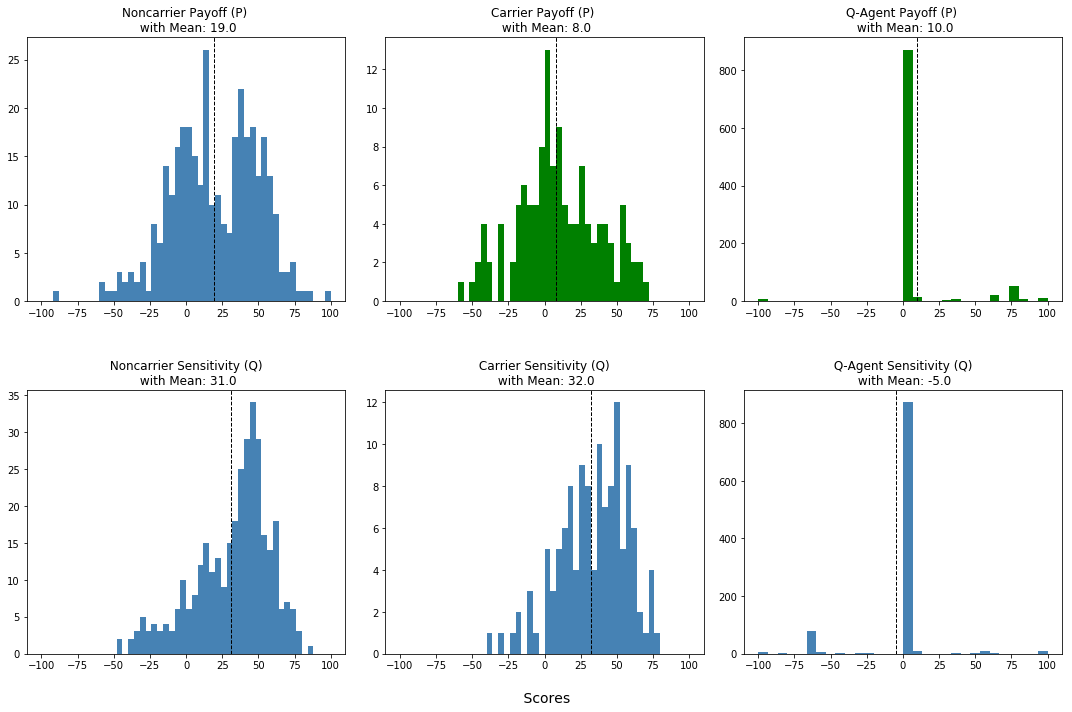

In [130]:
# alpha ratios in range .01-2 (.1 steps)
# beta = .01
# alpha gains = 10
testdf_8 = agent_df_2(.001, 1, .01, .1, 10)
agent_subject_comparison(testdf_8)

In [131]:
def agent_df_old(amin, amax, astep, given_beta):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(columns=df_columns)
    
    for cycle in np.arange(0, 10, 1): 
    
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(amin, amax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for denom in np.arange(amin, amax, astep):

                alpha_l = 1/denom

                #for beta in np.arange(0, 20, 5):
                beta = given_beta
                alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 1)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

In [ ]:
testdf = agent_df_old(.1, 15, .1, 10)
testdf = testdf.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(testdf)

In [ ]:
test = agent_df_old(1, 15, 1, .1)
test = test.groupby(['Alpha Gain', 'Alpha Loss'])['Beta', 'Payoff', 'Sensitivity'].mean().reset_index()
plot_heatmaps(test)